## Предсказание вероятности совершения покупки в течение 90 дней

**Описание проекта:**  

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель проекта:**  

Предсказать вероятность покупки в течение 90 дней

**Описание данных:**

Датасет состоит из пяти файлов: 

*apparel-purchases.csv* - данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук  
*apparel-messages.csv* - рассылки, которые были отправлены клиентам из таблицы покупок  
*full_campaign_daily_event.csv* - агрегация общей базы рассылок по дням и типам событий  
*full_campaign_daily_event_channel.csv* - агрегация по дням с учетом событий и каналов рассылки  
*apparel-target_binary* - целевой признак. Для каждого идентификатора клиента необходимо предсказать категориальное значение   соответствующее прогнозу [0, 1].

**Описание полей данных:**

apparel-purchases

*client_id* - идентификатор клиента  
*quantity* - количество единиц товара  
*price* - цена товара  
*category_ids* - идентификаторы категорий  
*date* - дата покупки  
*message_id* - идентификатор сообщения из рассылки  

apparel-messages

*bulk_campaign_id* - идентификатор рассылки  
*client_id* - идентификатор клиента  
*message_id* - идентификатор сообщения  
*event* - действие с сообщением (отправлено, открыто, покупка...)  
*channel* - канал рассылки  
*date* - дата действия  
*created_at* - дата-время полностью  

full_campaign_daily_event

*date* - дата  
*bulk_campaign_id* - идентификатор рассылки  
*count_event* - общее количество каждого события event  
*nunique_event* - количество уникальных client_id в каждом событии  

full_campaign_daily_event_channel

*date* - дата  
*bulk_campaign_id* - идентификатор рассылки  
*count_event_channel* - общее количество каждого события по каналам  
*nunique_event_channel* - количество уникальных client_id по событиям и каналам  

apparel-target_binary

*client_id* - идентификатор клиента  
*target* - клиент совершил покупку в целевом периоде  

**План работы:**

1. [Загрузка и ознакомление с данными](#section_id)
2. [Полноценный разведочный анализ](#section_id3)
3. [Разработка новых синтетических признаков](#section_id4)
4. [Проверка на мультиколлинеарность](#section_id5)
5. [Выбор и обучение моделей](#section_id6)
6. [Анализ важности признаков лучшей модели](#section_id7)
7. [Общий вывод](#section_id8)

Загружаем необходимые для выполнения проекта библиотеки:

In [1]:
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn
!pip install --upgrade shap matplotlib
!pip install matplotlib==3.4.3

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
f1_score, precision_score, recall_score, 
roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
)
import datetime
from datetime import timedelta
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')
!pip freeze > requirements.txt

  Using cached matplotlib-3.9.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached matplotlib-3.9.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0
  Using cached matplotlib-3.4.3-cp39-cp39-manylinux1_x86_64.whl.metadata (5.7 kB)
Using cached matplotlib-3.4.3-cp39-cp39-manylinux1_x86_64.whl (10.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.4
    Uninstalling matplotlib-3.9.4:
      Successfully uninstalled matplotlib-3.9.4


Создадим необходимые для дальнейшего обучения моделей константы:

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Настроим вывод всех строк и столбцов датафрейма, а также избавимся от научной нотации для всех чисел с плавающей точкой:

## 1. Загрузка и предварительная обработка данных <a id='section_id'></a>

Загрузим датасеты с тренировочными и тестовыми данными, выведем общую информацию о них и основные сатистические характеристики датасетов:

In [3]:
df_purchases = pd.read_csv(
    '/home/pc-mint/Загрузки/STD_M2_purchase_in_90_days/filtered_data/apparel-purchases.csv', parse_dates=['date']
)

In [4]:
df_messages = pd.read_csv(
    '/home/pc-mint/Загрузки/STD_M2_purchase_in_90_days/filtered_data/apparel-messages.csv', 
    parse_dates=['date', 'created_at']
)

In [5]:
df_daily_event = pd.read_csv(
    '/home/pc-mint/Загрузки/STD_M2_purchase_in_90_days/filtered_data/full_campaign_daily_event.csv'
)

In [6]:
df_daily_event_channel = pd.read_csv(
    '/home/pc-mint/Загрузки/STD_M2_purchase_in_90_days/filtered_data/full_campaign_daily_event_channel.csv'
)

In [7]:
df_target = pd.read_csv(
    '/home/pc-mint/Загрузки/STD_M2_purchase_in_90_days/filtered_data/apparel-target_binary.csv'
)

Выведем 10 случайных строк датасетов, для оценки корректности вывода

In [8]:
df_purchases.sample(10)

,client_id,quantity,price,category_ids,date,message_id
31824,1515915625471051130,1,299.0,"['4', '27', '287', '544']",2022-08-19,1515915625471051130-5922-62ff354452d55
107833,1515915625581786063,1,3529.0,"['4', '28', '62', '656']",2023-04-19,1515915625581786063-11760-6436749bbc769
4050,1515915625468168246,1,1499.0,"['4', '28', '260', '420']",2022-05-28,1515915625468168246-4617-6290658faa78f
22249,1515915625586495339,1,2999.0,"['4', '28', '260', '420']",2022-07-09,1515915625586495339-5368-62c834ea94902
145473,1515915625981508117,1,599.0,"['2', '18', '267', '1330']",2023-06-23,1515915625488431540-13392-649554e3339d3
112661,1515915625633761132,1,175.0,"['4', '27', '176', '458']",2023-04-28,1515915625633761132-12252-644bc95876709
135563,1515915625487443540,1,1049.0,"['4', '31', '324', '1431']",2023-06-11,1515915625487443540-13157-648319302c285
11056,1515915625613978412,1,999.0,"['2', '18', '258', '1562']",2022-06-04,1515915625613978412-4617-6290657f2622a
43459,1515915625591285565,1,1960.0,"['5562', '5631', '5549', '667']",2022-11-10,1515915625591285565-7687-636b57263770e
194094,1515915625561120249,1,149.0,"['6060', '6057', '6243', '6154']",2024-01-11,1515915625561120249-14458-659f972ca56c7


In [9]:
df_messages.sample(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
936607,5662,1515915625591286246,1515915625591286246-5662-62e0e62011c5a,send,email,2022-07-27,2022-07-27 07:47:19
9631627,14170,1515915625489271290,1515915625489271290-14170-655f119faf597,open,email,2023-11-23,2023-11-23 15:04:55
5603690,13319,1515915625487045798,1515915625487045798-13319-6483f57f655f1,send,mobile_push,2023-06-10,2023-06-10 04:21:09
7981304,13821,1515915625490149916,1515915625490149916-13821-650e9b8338641,send,mobile_push,2023-09-23,2023-09-23 14:37:18
5027969,12367,1515915625732208480,1515915625732208480-12367-6454f0f96c605,send,email,2023-05-05,2023-05-05 12:49:24
3875175,9801,1515915625608987986,1515915625608987986-9801-63da823313622,send,mobile_push,2023-02-01,2023-02-01 16:05:07
4427856,11031,1515915625500487912,1515915625500487912-11031-6414759c52011,open,mobile_push,2023-03-17,2023-03-17 14:38:42
460328,5080,1515915625470955035,1515915625470955035-5080-62b40f9898fa0,send,email,2022-06-23,2022-06-23 07:02:46
1744968,6859,1515915625491415656,1515915625491415656-6859-6336e864620c0,send,mobile_push,2022-09-30,2022-09-30 13:10:33
372161,4996,1515915625491289230,1515915625491289230-4996-62ac15f40a534,send,mobile_push,2022-06-17,2022-06-17 05:54:02


In [10]:
df_daily_event.sample(10)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
109972,2024-02-17,14657,43,0,0,2427,0,0,0,0,...,2404,0,0,0,0,37,0,0,0,0
9340,2022-07-14,3659,0,0,0,52,0,0,0,0,...,47,0,0,0,0,3,0,0,0,0
21036,2022-09-12,4922,0,0,0,5,0,0,0,0,...,5,0,0,0,0,1,0,0,0,0
124145,2024-04-17,14952,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60127,2023-03-01,8615,0,5,0,57,0,0,0,0,...,56,0,0,0,0,2,0,0,0,0
8358,2022-07-09,2090,0,0,0,8,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
58952,2023-02-23,2309,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107097,2024-02-04,14590,268,0,0,310,1,0,0,0,...,307,1,0,0,0,0,0,0,0,0
2011,2022-06-01,4548,1,0,0,40,0,0,0,0,...,32,0,0,0,0,2,0,0,0,0
49138,2023-01-13,2423,1,0,0,12,0,0,0,0,...,12,0,0,0,0,0,0,0,0,0


In [11]:
df_daily_event_channel.sample(10)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
90454,2023-10-26,13742,0,0,54,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61081,2023-03-07,5662,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
105312,2024-01-27,14437,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97012,2023-12-19,14309,0,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25337,2022-10-03,2003,0,0,36,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83978,2023-08-24,965,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118126,2024-03-24,13456,0,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50655,2023-01-19,2947,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
45344,2022-12-28,3987,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61594,2023-03-10,5840,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [12]:
df_target.sample(10)

,client_id,target
34454,1515915625590233557,0
40075,1515915625725536780,0
25548,1515915625557986026,0
41252,1515915625766036842,0
41494,1515915625770336693,0
14643,1515915625490718622,0
24890,1515915625555932920,0
1016,1515915625468143304,0
38165,1515915625645200422,0
14071,1515915625490523683,0


Данные успешно загружены и корректно отображаются во всех изучаемых датафреймах

Выведем общую информацию о загруженных датасетах:

In [13]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [14]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [15]:
df_messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [16]:
df_daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [17]:
df_daily_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

In [18]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Как видно, столбцы изучаемых датасетов не содержат пропусков. Также обратим внимание, что значения даты имеют строковый тип данных, на данный момент оставим их в таком виде, т.к. многие модели классификации не работают с данными типа date/datetime.

Выведем основные статистические характеристики датафреймов:

In [19]:
df_purchases.describe().T

,count,mean,std,min,25%,50%,75%,max
client_id,202208.0,1.515916e+18,1.459458e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
quantity,202208.0,1.006483e+00,1.843837e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+01
price,202208.0,1.193302e+03,1.342253e+03,1.000000e+00,3.520000e+02,9.870000e+02,1.699000e+03,8.549900e+04


In [20]:
df_messages.describe().T

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,12739798.0,1.160459e+04,3.259211e+03,5.480000e+02,8.746000e+03,1.351600e+04,1.415800e+04,1.465700e+04
client_id,12739798.0,1.515916e+18,1.329704e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18


In [21]:
df_daily_event.describe().T

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,131072.0,8416.743378,4877.369306,548.0,4116.0,7477.0,13732.0,15150.0
count_click,131072.0,90.982971,1275.503564,0.0,0.0,0.0,2.0,128453.0
count_complain,131072.0,0.932655,30.198326,0.0,0.0,0.0,0.0,5160.0
count_hard_bounce,131072.0,78.473434,1961.317826,0.0,0.0,0.0,0.0,287404.0
count_open,131072.0,3771.090691,65160.668444,0.0,1.0,6.0,30.0,5076151.0
count_purchase,131072.0,0.577927,9.107040,0.0,0.0,0.0,0.0,1077.0
count_send,131072.0,11634.142319,175709.508290,0.0,0.0,0.0,0.0,11543513.0
count_soft_bounce,131072.0,27.807312,736.944714,0.0,0.0,0.0,0.0,76284.0
count_subscribe,131072.0,0.140518,2.072777,0.0,0.0,0.0,0.0,189.0
count_unsubscribe,131072.0,6.362679,79.172069,0.0,0.0,0.0,1.0,9089.0


In [22]:
df_daily_event_channel.describe().T

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,131072.0,8416.743378,4877.369306,548.0,4116.0,7477.0,13732.0,15150.0
count_click_email,131072.0,41.582169,745.484035,0.0,0.0,0.0,1.0,59365.0
count_click_mobile_push,131072.0,49.400803,1036.952898,0.0,0.0,0.0,0.0,128453.0
count_open_email,131072.0,423.706032,9753.383722,0.0,1.0,5.0,23.0,2597015.0
count_open_mobile_push,131072.0,3347.384659,64448.590783,0.0,0.0,0.0,0.0,5076151.0
count_purchase_email,131072.0,0.357483,8.287483,0.0,0.0,0.0,0.0,1077.0
count_purchase_mobile_push,131072.0,0.220444,3.796500,0.0,0.0,0.0,0.0,431.0
count_soft_bounce_email,131072.0,24.474823,727.069387,0.0,0.0,0.0,0.0,76284.0
count_subscribe_email,131072.0,0.140518,2.072777,0.0,0.0,0.0,0.0,189.0
count_unsubscribe_email,131072.0,6.362679,79.172069,0.0,0.0,0.0,1.0,9089.0


In [23]:
df_target.describe().T

,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,49849.0,1.927822e-02,1.375025e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Проверим изучаемые датасеты на наличие явных дубликатов:

In [24]:
df_purchases.duplicated().sum()

73020

In [25]:
df_messages.duplicated().sum()

48610

In [26]:
df_daily_event.duplicated().sum()

0

In [27]:
df_daily_event_channel.duplicated().sum()

0

In [28]:
df_target.duplicated().sum()

0

Удалим выявленные дубликаты из датасетов df_purchases и df_messages:

In [29]:
df_messages = df_messages.drop_duplicates().reset_index(drop=True)

In [30]:
df_purchases = df_purchases.drop_duplicates().reset_index(drop=True)

Проверим что удаление дубликатов прошло успешно:

In [31]:
df_messages.duplicated().sum()

0

In [32]:
df_purchases.duplicated().sum()

0

При исследовании данных была выявлена следующая аномалия: в некоторых строках датасета df_purchases наблюдается несоответствие между значением столбца 'client_id' и первой частью столбца 'message_id' (например строка с индексом 129187 ниже), хотя для большинсва строк датасета эти значения идентичны.

In [33]:
df_purchases.iloc[[129187]]

,client_id,quantity,price,category_ids,date,message_id
129187,1515915626010443624,1,999.0,"['4', '28', '62', '656']",2024-02-16,1515915625488468007-14668-65cf5234b1295


**Вывод:**   
В рамках данного раздела:
- загружены необходимые для исследования датасеты;
- датасеты проверены на корректность вывода;
- датасет проверен на наличие пропусков в данных (пропуски не выявлены);
- данные проверены на наличие явных дубликатов, выяыленные дубликаты удалены из датасета;
- значения, отображающие даты событий, переведены из строкового формата в формат datetime;

<a id='section_id3'></a>

## 2. Полноценный разведочный анализ

Рассмотрим подробнее распределение значений количественных и категориальных значений входящих признаков. Для построения графиков описывающих такое распределение, будем использовать следующие функции:

Для количественных значений:

In [34]:
def num_stat_and_graph(df, col, n, title):
    stat = df[col].describe()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    sns.histplot(df[col], bins=n, ax=axes[0])
    sns.boxplot(data=df, x=col)
    fig.suptitle(title);
    return stat

Для категориальных значений:

In [35]:
def count_graph(df, col, name, a, b):
    fig, ax = plt.subplots(figsize=(a,b))
    ax = sns.countplot(y=df[col],
         order=df[col].value_counts(ascending=False).index);
    abs_values = df[col].value_counts(ascending=False).values
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title(name);

Начнем с признаков датасета df_purchases:

In [36]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Изучим распределение параметра 'quantity'

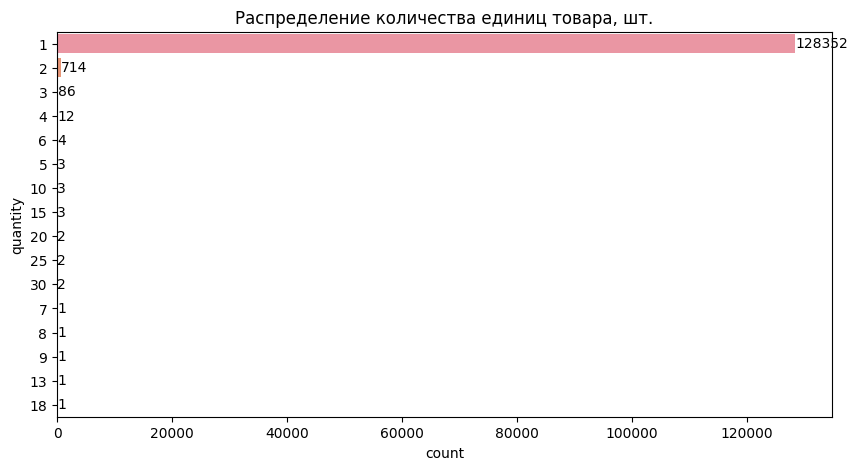

In [37]:
count_graph(df_purchases, 'quantity', 'Распределение количества единиц товара, шт.', 10, 5)

Как видно из графика выше, в столбце 'quantity' абсолютное большинство значений равно 1. Остальные значения составляют крайне незначительную часть датасета. Необходимо уточнить принцип формирования данного столбца, т.к. таоке првалирование значения 1 выглядит аномальным.

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

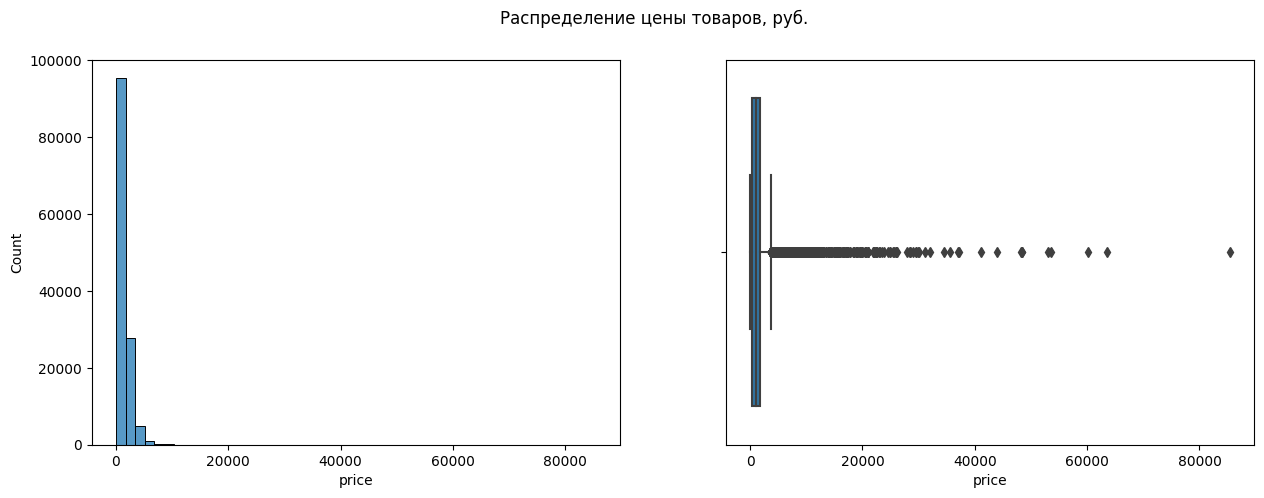

In [38]:
num_stat_and_graph(df_purchases, 'price', 50, 'Распределение цены товаров, руб.')

Как видно из графика и таблицы выше, подавляющее большинство значений столбца 'price' находится в диапазоне до 10_000. Рассмотрим этот дипазон значений подробнее:

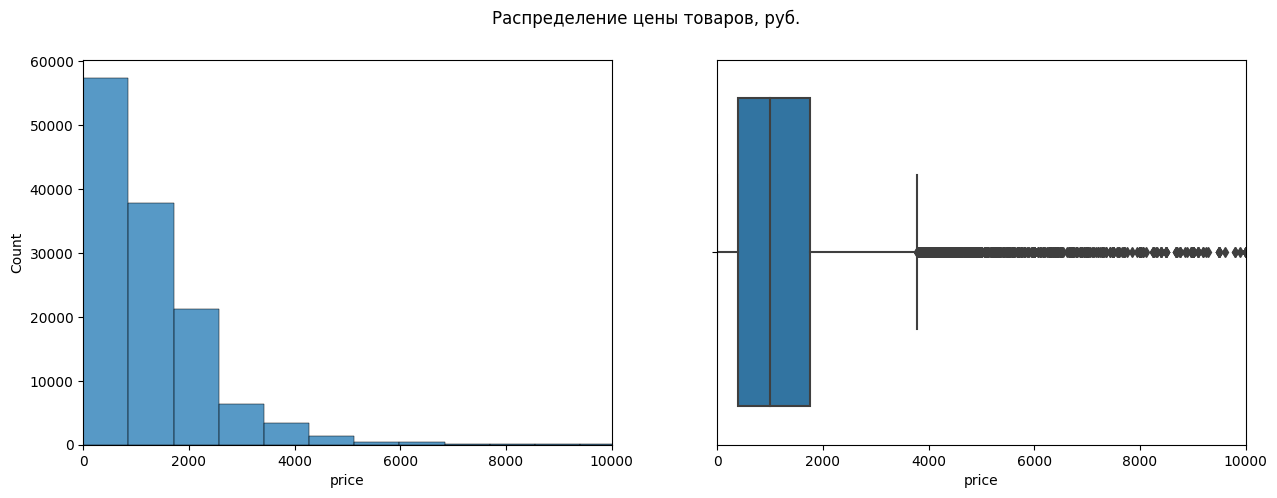

In [39]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(df_purchases['price'], bins=100, ax = axes[0])
axes[0].set_xlim(0,10_000)
sns.boxplot(data=df_purchases, x= 'price')
axes[1].set_xlim(0,10_000)
fig.suptitle('Распределение цены товаров, руб.');

Также рассмотрим диапазон значений стоимости товара 5_000 - 15_000:

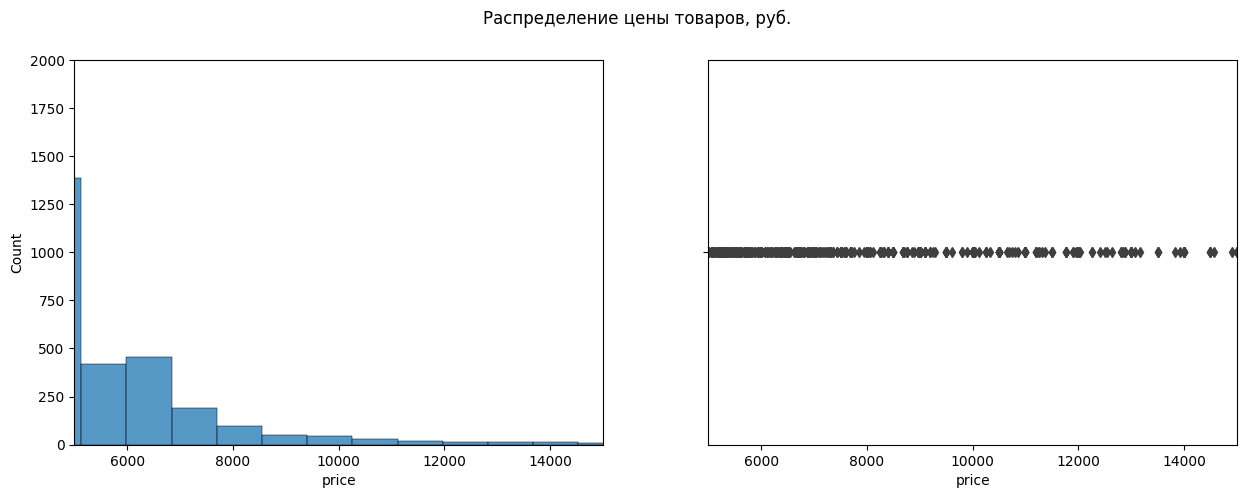

In [40]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(df_purchases['price'], bins=100, ax = axes[0])
axes[0].set_xlim(5_000,15_000)
axes[0].set_ylim(0,2_000)
sns.boxplot(data=df_purchases, x= 'price')
axes[1].set_xlim(5_000,15_000)
fig.suptitle('Распределение цены товаров, руб.');

Как видно из графиков выше, в диапазоне 0-10_000 большинство значений стоимости попадают в отрезок 0-2500, затем следует спад до 5_000 и затем снова довольно резкое падений количества значений. При этом, несмотря на то, что "ящик с усами" счиатет значения более 4000 аномалиями, нет оснований так считать, т.к. в этом диапазоне представлены вполне реальные значения стоимости. Нулевые значения стоимости в датасете отсутствуют. Цена значенияем в 1 вызывает вопросы, однако она реальна, тем более что валюта в которой идет расчет, нам неизвестна

Так как столбец 'category_ids' содержит большое количество уникальных значений, отображение его содержимого в графическом виде затруднительно, пожтому выведем топ-50 самых часто встречающихся категорий покупок, а также 50 категорий-аутсайдеров:

In [41]:
df_purchases['category_ids'].value_counts().head(20)

['4', '28', '57', '431']     6191
['4', '28', '244', '432']    4835
['4', '28', '260', '420']    4421
['4', '28', '275', '421']    3309
['2', '18', '258', '441']    3175
['4', '28', '62', '657']     2841
[]                           2738
['4', '28', '124', '415']    2735
['4', '28', '62', '656']     2485
['4', '28', '275', '673']    2322
['4', '28', '290', '422']    2080
['4', '28', '213', '436']    2075
['4', '28', '343', '425']    2037
['4', '31', '326', '505']    1867
['2', '18', '344', '445']    1487
['4', '28', '249', '616']    1399
['4', '28', '146', '548']    1378
['2', '18', '61', '661']     1316
['4', '28', '49', '413']     1299
['4', '28', '58', '434']     1293
Name: category_ids, dtype: int64

In [42]:
df_purchases['category_ids'].value_counts().tail(20)

['5562', '5589', '5613', '1726']    1
['5562', '5597', '5642', '900']     1
['5963', '5959', '6020', '1800']    1
['4', '5837', '5836', '839']        1
['4', '5837', '6013', '1607']       1
['5562', '5558', '5617', '1102']    1
['6060', '6057', '6245', '6305']    1
['5963', '5959', '6021', '999']     1
['5562', '5632', '5552', '1089']    1
['4', '27', '350', '1589']          1
['5', '10', '105', '1794']          1
['6060', '6057', '6074', '1211']    1
['4', '27', '278', '471']           1
['5562', '5632', '5639', '1629']    1
['4', '27', '336', '1854']          1
['5562', '5597', '5696', '1429']    1
['5562', '5597', '5696', '751']     1
['5562', '5589', '5624', '1696']    1
['4', '28', '239', '6202']          1
['4', '44', '1600']                 1
Name: category_ids, dtype: int64

Аналогичная ситуация с ото,ражением столбца 'date', столбец содержит большое количество уникальных данных. пожтому выведем топ-20 чаще всего встречающихся дат и 20 дат-"аутсайдеров", а также выведем максимальное и минимальное значние столбца.

In [43]:
df_purchases['date'].value_counts().head(20)

2022-11-11    2808
2023-06-10    2356
2023-04-28    1985
2022-06-02    1756
2022-11-15    1656
2022-12-22    1485
2022-11-12    1463
2022-12-21    1448
2022-06-01    1434
2022-06-03    1396
2023-06-11    1294
2022-11-13    1173
2022-06-04    1165
2022-12-16    1144
2023-04-14    1052
2023-06-09    1040
2023-11-10    1028
2023-07-12     995
2022-07-08     960
2023-06-23     930
Name: date, dtype: int64

In [44]:
df_purchases['date'].value_counts().tail(20)

2023-07-16    7
2022-10-16    7
2023-01-01    7
2023-02-26    6
2023-01-10    6
2023-11-19    6
2022-10-12    6
2023-01-07    6
2022-09-19    6
2023-11-05    5
2022-10-25    5
2022-10-13    5
2022-09-21    4
2023-10-22    4
2023-08-06    4
2023-01-16    4
2023-01-09    3
2023-01-29    2
2022-10-06    2
2023-10-29    2
Name: date, dtype: int64

In [45]:
df_purchases['date'].min()

Timestamp('2022-05-16 00:00:00')

In [46]:
df_purchases['date'].max()

Timestamp('2024-02-16 00:00:00')

Минимальная дата столбца 'date' это 16-05-2022, максимальная: 16-02-2024. При этом в рапсределении 20 самых редко и часто встречающихся дат каких либо закономерностей не выявлено.

Исследование столбцов 'client_id' и 'message_id' выполнять не будем, т.к. они являются идентификационными номерами соответственно клиентов и сообщений.

Исследуем значения столбцов датасета df_messages:

In [47]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


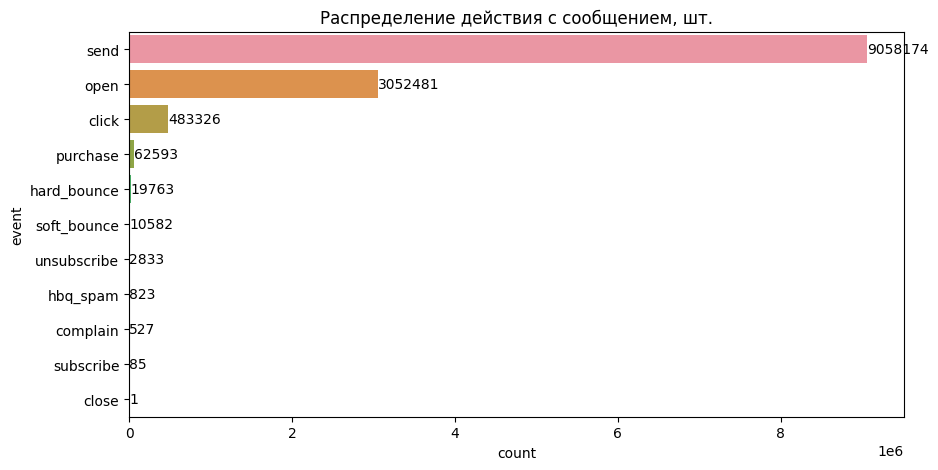

In [48]:
count_graph(df_messages, 'event', 'Распределение действия с сообщением, шт.', 10, 5)

Как видно из графика выше, первые четыре значения составляют воронку покупки (отправлено-открыто-клик-покупка), далее следуют действия которые не попадабт в воронку - не доставлено, отписка, спам, жалоба, подписка, закрыто)

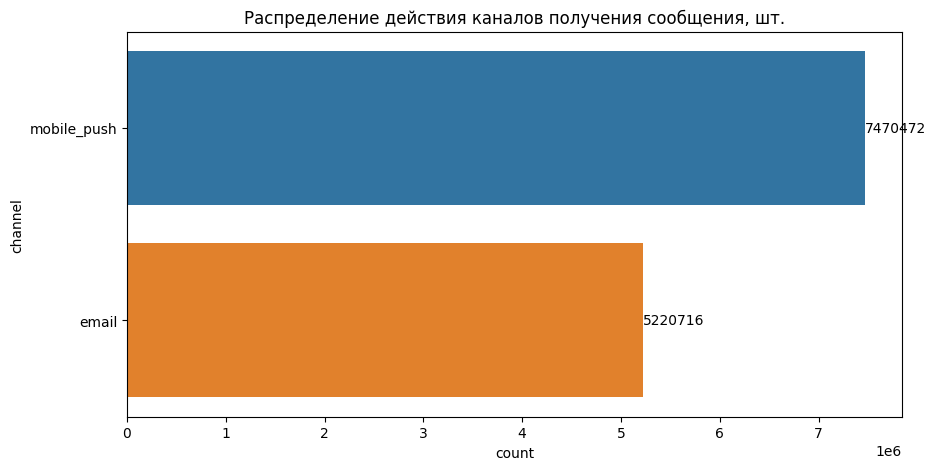

In [49]:
count_graph(df_messages, 'channel', 'Распределение действия каналов получения сообщения, шт.', 10, 5)

Как видно из графика выше, большинство сообщений напрвляется клиентам с помощью мобильных push-уведомлений, однако количество направляемых посредством email сообщений, также значительно

In [50]:
df_messages['date'].value_counts().head(20)

2023-06-10    89173
2024-01-26    84242
2023-12-11    82568
2023-12-10    81352
2023-12-26    80116
2023-12-22    77704
2024-01-11    74219
2024-02-09    72652
2023-09-27    72326
2024-01-30    69166
2024-02-13    68944
2024-01-19    64255
2023-12-09    63534
2023-12-29    62894
2023-08-11    61785
2023-11-21    61107
2023-04-28    60671
2024-01-23    59638
2023-10-06    59350
2023-11-10    58819
Name: date, dtype: int64

In [51]:
df_messages['date'].value_counts().tail(20)

2022-10-30    433
2023-01-09    423
2023-10-01    423
2022-10-16    419
2023-07-16    398
2023-08-13    392
2023-07-30    389
2023-04-02    385
2023-05-08    380
2023-02-25    374
2023-01-29    371
2023-06-18    361
2023-02-28    360
2023-05-14    330
2023-02-26    288
2023-01-08    278
2023-04-11    273
2023-01-07    259
2023-05-09    250
2023-07-02    104
Name: date, dtype: int64

In [52]:
df_messages['date'].min()

Timestamp('2022-05-19 00:00:00')

In [53]:
df_messages['date'].max()

Timestamp('2024-02-15 00:00:00')

Минимальная дата столбца 'date' это 19-05-2022 (в датасете df_purchases была 16-05-2022), максимальная: 15-02-2024 (в датасете df_purchases была 16-02-2024). Также можно обратить внимание что в топ-20 самых часто встречающихся дат представлен только 2023 и 2024 год, в то время когда в топ-20 часто встречающихся дат датасета df_purchases представлены даты только 2022 и 2023 года.

Исследование столбцов 'client_id', 'message_id' и эbulk_campaign_idэ выполнять не будем, т.к. они являются идентификационными номерами соответственно клиентов, сообщений и рассылок.

Рассмотрим значения столбца 'target' датасета df_target:

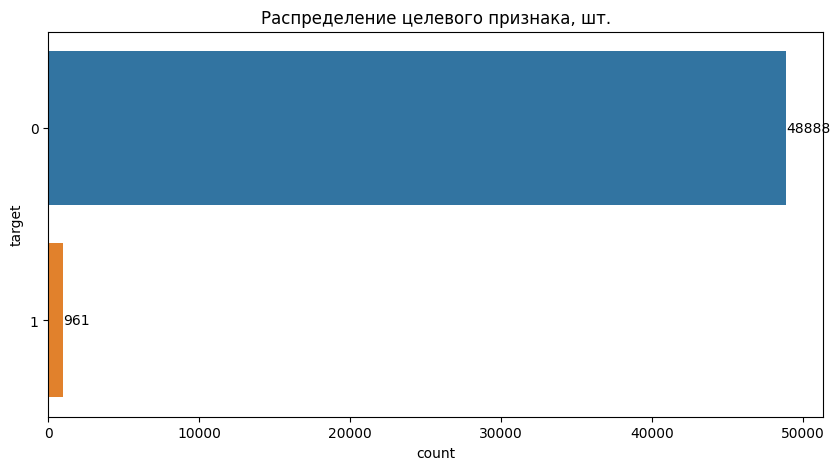

In [54]:
count_graph(df_target, 'target', 'Распределение целевого признака, шт.', 10, 5)

Как видно из графика выше, в значениях целевого признака имеется сильный дисбаланс - количество клиентов имеющих метку 0 (клиент не сделает покупку) сильно превалирует над количеством клиентов с меткой 1 (клиент сделает покупку).

Исследовательский анализ датасетов df_daily_event и df_daily_event_channel выполнять не будем, т.к. они являются агрегацией по дням и типам событий 

**Вывод:**  
Проведен исследовательский анализ данных датасетов df_purchaeses, df_messages и df_target:
-  выявлено сильное преобладание значения 1 в столбце 'quantity' датасета df_purchases;
-  выявлено различие между минимальной и максимальной датой датасетов df_purchases и df_messages, также выявлено что топ-20 самых распространенных значений дат датасета df_purchases представлены годами 2022 и 2023, в то время когда топ-20 датасета df_messages представлены годами 2023 и 2024;
-  выявлен дисбаланс в значениях целевого признака: количество клиентов имеющих метку 0 (клиент не сделает покупку) сильно превалирует над количеством клиентов с меткой 1 (клиент сделает покупку).

<a id='section_id4'></a>

## 3. Разработка новых синтетических признаков

В датасете df_purchases создаем новый синтетический призак 'quantity_90', который будет отображать количество покупок, сделанных в последние 90 дней.

Сохраним максимальную дату датасета в переменную date_max:

In [55]:
date_max = df_purchases['date'].max()
date_max

Timestamp('2024-02-16 00:00:00')

Также создадим переменную date_90 - дата полученная вычитанием 90 дней от максимальной даты date_max

In [56]:
date_90 = date_max - pd.Timedelta(days=90)
date_90

Timestamp('2023-11-18 00:00:00')

Создадим столбец 'quantity_90' заполненный нулями:

In [57]:
df_purchases['quantity_90'] = 0

Будем менять значение 0 на соответствующее значение столбца 'quantity', в случае если дата покупки была позднее, чем значение date_90 (то есть была в последние 90 дней)

In [58]:
for i in range(len(df_purchases)):
    if df_purchases['date'][i] > date_90:
        df_purchases['quantity_90'][i] =  df_purchases['quantity'][i]

In [59]:
df_purchases['month'] = pd.Series(map(lambda x: x.month, df_purchases['date']))

Выведем "голову" и "хвост" датасета, чтобы проверить что новые признаки создано корректно

In [60]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,quantity_90,month
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,5
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,5
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5


Также создадим признак, который содержит номер месяца совершения покупки - 'month':

In [61]:
df_purchases.tail()

,client_id,quantity,price,category_ids,date,message_id,quantity_90,month
129183,1515915626010221592,1,1499.0,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9,1,2
129184,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,1,2
129185,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,1,2
129186,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,1,2
129187,1515915626010443624,1,999.0,"['4', '28', '62', '656']",2024-02-16,1515915625488468007-14668-65cf5234b1295,1,2


Создадим новый датасет, который будет содержать тех клиентов, у которых есть несколько покупок в разные дни.

Сначала создадим датасет  purchases_diff_days содержащий id клиентов и даты покупок

In [62]:
purchases_diff_days = df_purchases[['client_id', 'date']]

In [63]:
purchases_diff_days.head()

,client_id,date
0,1515915625468169594,2022-05-16
1,1515915625468169594,2022-05-16
2,1515915625471138230,2022-05-16
3,1515915625471138230,2022-05-16
4,1515915625471138230,2022-05-16


Т.к. покупки совершенные в один день нас не интересуют, удалим из созданного датасета дубли

In [64]:
purchases_diff_days.duplicated().sum()

68980

In [65]:
purchases_diff_days = purchases_diff_days.drop_duplicates()

In [66]:
purchases_diff_days.head()

,client_id,date
0,1515915625468169594,2022-05-16
2,1515915625471138230,2022-05-16
5,1515915625471640575,2022-05-16
6,1515915625490211585,2022-05-16
7,1515915625490739153,2022-05-16


Сгруппируем датасет по 'client_id' и выведем сколько раз уникальные даты покупок встречаются в отфильтрованном датасете. Это и будет количесво покупок в разные дни

In [67]:
purchases_diff_days = purchases_diff_days.groupby('client_id')['date'].count().reset_index()

In [68]:
purchases_diff_days.columns=['client_id', 'purchase_row']

Оставим в датасете только тех клиентов, которые делали покупки в разные дни, потом при объединении с основным датасетом заменим пропущенные значения на 0, чтобы показать модели, что у людей совершивших покупки более чем в один день, имеется некий приоритет

In [69]:
purchases_diff_days = purchases_diff_days[purchases_diff_days['purchase_row'] > 1]

Выведем первые значения итогового датасета:

In [70]:
purchases_diff_days.head()

,client_id,purchase_row
4,1515915625468061170,3
8,1515915625468061994,2
9,1515915625468062158,2
15,1515915625468062659,2
19,1515915625468063026,3


Также разобьем значения столбца 'category_ids' на отдельные значения 'cat1', 'cat2', 'cat3', 'cat4', 'cat5':

In [71]:
df_purchases['category_ids_'] = df_purchases['category_ids'].apply(ast.literal_eval)

In [72]:
df_purchases[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']] = pd.DataFrame(
    df_purchases['category_ids_'].apply(lambda x: (x + ['0'] * 5)[:5]).to_list(), 
    index=df_purchases.index
)

Проверим есть ли в созданных столбцах пропуски:

In [73]:
df_purchases[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']].isna().sum()

cat1    622
cat2      0
cat3      0
cat4      0
cat5      0
dtype: int64

Заменим выявленные пропуски в столбце 'cat1' на 0

In [74]:
df_purchases['cat1'] = df_purchases['cat1'].fillna('0')

Проверим что пропуски удалены, а также посмотрим какой тип данных содержат новые признаки. 

In [75]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      129188 non-null  int64         
 1   quantity       129188 non-null  int64         
 2   price          129188 non-null  float64       
 3   category_ids   129188 non-null  object        
 4   date           129188 non-null  datetime64[ns]
 5   message_id     129188 non-null  object        
 6   quantity_90    129188 non-null  int64         
 7   month          129188 non-null  int64         
 8   category_ids_  129188 non-null  object        
 9   cat1           129188 non-null  object        
 10  cat2           129188 non-null  object        
 11  cat3           129188 non-null  object        
 12  cat4           129188 non-null  object        
 13  cat5           129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(8

Переведем значения 'cat1', 'cat2', 'cat3', 'cat4', 'cat5' из типа object в значение int

In [76]:
df_purchases[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']] = df_purchases[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']].astype('int')

In [77]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      129188 non-null  int64         
 1   quantity       129188 non-null  int64         
 2   price          129188 non-null  float64       
 3   category_ids   129188 non-null  object        
 4   date           129188 non-null  datetime64[ns]
 5   message_id     129188 non-null  object        
 6   quantity_90    129188 non-null  int64         
 7   month          129188 non-null  int64         
 8   category_ids_  129188 non-null  object        
 9   cat1           129188 non-null  int64         
 10  cat2           129188 non-null  int64         
 11  cat3           129188 non-null  int64         
 12  cat4           129188 non-null  int64         
 13  cat5           129188 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(9), object(3

Создадим новый признак 'revenue' - выручка, который является произведением  значений столбцов 'price' и 'quantity'

In [78]:
df_purchases['revenue'] = df_purchases['price'] * df_purchases['quantity']

Выведем первые пять строк датасета:

In [79]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,quantity_90,month,category_ids_,cat1,cat2,cat3,cat4,cat5,revenue
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,5,"[4, 28, 57, 431]",4,28,57,431,0,1999.0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,5,"[4, 28, 57, 431]",4,28,57,431,0,2499.0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5,"[4, 28, 57, 431]",4,28,57,431,0,6499.0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5,"[4, 28, 244, 432]",4,28,244,432,0,4999.0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5,"[4, 28, 49, 413]",4,28,49,413,0,4999.0


Т.к. для каждого 'client_id' в датасете имеется несколько строк. для удобства дальнейшего использования датасета выполним группировку по 'client_id'.

Напишем функцию, которая при группировке будет выбирать самое часто встречающееся значение в столбце:

In [80]:
def most_frequent(series):

    return series.mode().iloc[0] if not series.mode().empty else None

In [81]:
df_purchases_group = (
    df_purchases.groupby('client_id')
                .agg({'quantity': 'sum',
                      'price': 'sum',
                      'category_ids': 'nunique',
                      'cat1': most_frequent,
                      'cat2': most_frequent,
                      'cat3': most_frequent,
                      'cat4': most_frequent,
                      'cat5': most_frequent,
                      'date': ['min', 'max'],
                      'quantity_90': 'sum',
                      'revenue': 'mean',
                      'month': most_frequent
                      
                     }).reset_index()
)                  

In [82]:
df_purchases_group.columns = [
    'client_id', 'quantity', 'price', 'category', 'cat1', 'cat2', 
    'cat3', 'cat4', 'cat5', 'date_min', 'date_max', 'quantity_90', 'revenue', 'month'
    ]

Выведем первые пять строк полученного датасета:

In [83]:
df_purchases_group.head()

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,date_max,quantity_90,revenue,month
0,1515915625468060902,5,4795.0,5,4,28,176,420,0,2022-05-27,2022-05-27,0,959.000000,5
1,1515915625468061003,6,14135.0,1,4,28,249,615,0,2023-01-04,2023-01-04,0,2355.833333,1
2,1515915625468061099,1,299.0,1,4,28,290,424,0,2022-05-17,2022-05-17,0,299.000000,5
3,1515915625468061100,1,1049.0,1,4,27,1828,5717,0,2024-02-10,2024-02-10,1,1049.000000,2
4,1515915625468061170,8,14102.0,4,4,28,260,420,0,2023-03-26,2023-06-17,0,1762.750000,3


Также проверим его размерность:

In [84]:
df_purchases_group.shape[0]

49849

Выполним объединение датасета df_purchases_group с ранее созданным датасетом purchases_diff_days, содержащим информацию, о количестве дней, в которые клиент совершал покупки

In [85]:
df_purchases_group = df_purchases_group.merge(purchases_diff_days, on = 'client_id', how='left')

Пропуски в новом столбце заменим на 0

In [86]:
df_purchases_group['purchase_row'] = df_purchases_group['purchase_row'].fillna(0)

Переведем даты в формат единого числа, например: дата 2022-05-27 трансформируется в число 20220527 

In [87]:
df_purchases_group['date_min'] = (
                             df_purchases_group['date_min']
                                .astype('str')
                                .str.replace('-', '')
                                .astype('int')
)

In [88]:
df_purchases_group['date_max'] = (
                             df_purchases_group['date_min']
                                .astype('str')
                                .str.replace('-', '')
                                .astype('int')
)

In [89]:
df_purchases_group['date_max'].max()

20240216

Создадим новый признак 'delta_date' - разница между самой поздней покупкой в датасете и самой поздней покупкой у конкретного клиента:

In [90]:
df_purchases_group['delta_date'] = df_purchases_group['date_max'].max() - df_purchases_group['date_max']

Выведем первые пять строк итогового датасета:

In [91]:
df_purchases_group.head()

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,date_max,quantity_90,revenue,month,purchase_row,delta_date
0,1515915625468060902,5,4795.0,5,4,28,176,420,0,20220527,20220527,0,959.000000,5,0.0,19689
1,1515915625468061003,6,14135.0,1,4,28,249,615,0,20230104,20230104,0,2355.833333,1,0.0,10112
2,1515915625468061099,1,299.0,1,4,28,290,424,0,20220517,20220517,0,299.000000,5,0.0,19699
3,1515915625468061100,1,1049.0,1,4,27,1828,5717,0,20240210,20240210,1,1049.000000,2,0.0,6
4,1515915625468061170,8,14102.0,4,4,28,260,420,0,20230326,20230326,0,1762.750000,3,3.0,9890


Также выполним группировку по 'client_id' для датасета df_messages:

In [92]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [93]:
df_messages_group = (
    df_messages.groupby('client_id')
                .agg({'bulk_campaign_id': 'nunique',
                      'message_id': 'nunique'
                     }).reset_index()
)                  

Выведем первые 5 строк сгруппированного датасета

In [94]:
df_messages_group.head()

,client_id,bulk_campaign_id,message_id
0,1515915625468060902,127,127
1,1515915625468061003,154,154
2,1515915625468061099,215,215
3,1515915625468061100,265,268
4,1515915625468061170,240,243


Объединим датасеты df-purchases_group и df_messages_group в датасет df_group:

In [95]:
df_group = df_purchases_group.merge(df_messages_group, on = 'client_id', how='left')

In [96]:
df_group.head()

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,date_max,quantity_90,revenue,month,purchase_row,delta_date,bulk_campaign_id,message_id
0,1515915625468060902,5,4795.0,5,4,28,176,420,0,20220527,20220527,0,959.000000,5,0.0,19689,127.0,127.0
1,1515915625468061003,6,14135.0,1,4,28,249,615,0,20230104,20230104,0,2355.833333,1,0.0,10112,154.0,154.0
2,1515915625468061099,1,299.0,1,4,28,290,424,0,20220517,20220517,0,299.000000,5,0.0,19699,215.0,215.0
3,1515915625468061100,1,1049.0,1,4,27,1828,5717,0,20240210,20240210,1,1049.000000,2,0.0,6,265.0,268.0
4,1515915625468061170,8,14102.0,4,4,28,260,420,0,20230326,20230326,0,1762.750000,3,3.0,9890,240.0,243.0


In [97]:
df_group.shape[0]

49849

Выведем количество всех возможных значений столбца 'event' в отдельных столбцах  и сгруппируем (просуммируем) их по значению 'client_id'

In [98]:
events = (pd.get_dummies(df_messages[['client_id', 'event']], 
                                 columns=['event']))

In [99]:
events.head()

,client_id,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe
0,1515915625626736623,0,0,0,0,0,1,0,0,0,0,0
1,1515915625490086521,0,0,0,0,0,1,0,0,0,0,0
2,1515915625553578558,0,0,0,0,0,1,0,0,0,0,0
3,1515915625553578558,1,0,0,0,0,0,0,0,0,0,0
4,1515915625471518311,0,0,0,0,0,1,0,0,0,0,0


In [100]:
events = events.groupby('client_id').sum().reset_index()

In [101]:
events.head()

,client_id,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0
1,1515915625468061003,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0
3,1515915625468061100,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0
4,1515915625468061170,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0


Выведем количество всех возможных значений столбца 'channels' в отдельных столбцах  и сгруппируем (просуммируем) их по значению 'client_id'

In [102]:
channels = (pd.get_dummies(df_messages[['client_id', 'channel']], 
                                   columns=['channel']))

In [103]:
channels.head()

,client_id,channel_email,channel_mobile_push
0,1515915625626736623,1,0
1,1515915625490086521,1,0
2,1515915625553578558,1,0
3,1515915625553578558,1,0
4,1515915625471518311,1,0


In [104]:
channels = channels.groupby('client_id').sum().reset_index()

In [105]:
channels.head()

,client_id,channel_email,channel_mobile_push
0,1515915625468060902,177.0,0.0
1,1515915625468061003,165.0,0.0
2,1515915625468061099,182.0,94.0
3,1515915625468061100,0.0,428.0
4,1515915625468061170,202.0,91.0


Соеденим полученные датафреймы enents и channels с ранее сформированным датасетом df_group

In [106]:
df_group = df_group.merge(events, on = 'client_id', how='left')

In [107]:
df_group = df_group.merge(channels, on = 'client_id', how='left')

In [108]:
df_group.head()

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,...,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push
0,1515915625468060902,5,4795.0,5,4,28,176,420,0,20220527,...,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,177.0,0.0
1,1515915625468061003,6,14135.0,1,4,28,249,615,0,20230104,...,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,165.0,0.0
2,1515915625468061099,1,299.0,1,4,28,290,424,0,20220517,...,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,182.0,94.0
3,1515915625468061100,1,1049.0,1,4,27,1828,5717,0,20240210,...,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,0.0,428.0
4,1515915625468061170,8,14102.0,4,4,28,260,420,0,20230326,...,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,202.0,91.0


Также присоеденим к датасету df_group датасет df_target

In [109]:
df_group.shape[0]

49849

In [110]:
df_target.shape[0]

49849

In [111]:
df_group = df_group.merge(df_target, on = 'client_id')

In [112]:
df_group.shape[0]

49849

Выполним проверку итогового датасета на наличие пропусков:

In [113]:
df_group.isna().sum()

client_id                 0
quantity                  0
price                     0
category                  0
cat1                      0
cat2                      0
cat3                      0
cat4                      0
cat5                      0
date_min                  0
date_max                  0
quantity_90               0
revenue                   0
month                     0
purchase_row              0
delta_date                0
bulk_campaign_id       7867
message_id             7867
event_click            7867
event_close            7867
event_complain         7867
event_hard_bounce      7867
event_hbq_spam         7867
event_open             7867
event_purchase         7867
event_send             7867
event_soft_bounce      7867
event_subscribe        7867
event_unsubscribe      7867
channel_email          7867
channel_mobile_push    7867
target                    0
dtype: int64

Т.к. пропуски обусловлены отстутсвием некоторых значений client_id из датасета df_purchases в датасете df_messages,заменим их на значение 0.

In [114]:
df_group = df_group.fillna(0)

Проверим что пропуски удалены:

In [115]:
df_group.isna().sum()

client_id              0
quantity               0
price                  0
category               0
cat1                   0
cat2                   0
cat3                   0
cat4                   0
cat5                   0
date_min               0
date_max               0
quantity_90            0
revenue                0
month                  0
purchase_row           0
delta_date             0
bulk_campaign_id       0
message_id             0
event_click            0
event_close            0
event_complain         0
event_hard_bounce      0
event_hbq_spam         0
event_open             0
event_purchase         0
event_send             0
event_soft_bounce      0
event_subscribe        0
event_unsubscribe      0
channel_email          0
channel_mobile_push    0
target                 0
dtype: int64

Также проверим итоговый датасет на наличие явных дубликатов:

In [116]:
df_group.duplicated().sum()

0

**Вывод:**   
Сформированы следующие синтетические признаки:
- 'quantity_90' - количество товаров, приобретенных в последние 90 дней;
- 'month' - номер месяца покупки;
- 'revenue' - выручка полусченная от клиента;
- 'cat1', 'cat2', 'cat3', 'cat4', 'cat5' - уровни категорий по стоkбцу 'category_ids';
- 'purchase_row' - количество дней,  в которые были совершены покупки (если таких дней было более 1)
- 'date_min' - минимальная дата покупки;
- 'date_max' - максимальная дата покупки;
- 'delta_date' - разница между самой поздней покупкой в датасете и самой поздней покупкой у конкретного клиента;
- 'event_X' - где X это все уникальные значения столбца event;
- 'channel_X' - где X это все уникальные значения столбца channel.

<a id='section_id5'></a>

## 4. Проверка на мультиколлинеарность

Проверим на мультиколлинеарность входящие признаки датасета, путем составляения матрицы корреляции. Так как все имеющемся в датасете признаки количественные и среди них отсутствуют нормально распределенные параметры, при составлении матрицы корреляции будем использвать коэффициент Спирмена. Phik матрицу использовать не будем, ввиду отсутствия категориальных параметров:

In [117]:
corr_spearman = df_group.corr(method='spearman')

In [118]:
corr_spearman

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,...,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,target
client_id,1.000000,-0.024171,-0.030234,-0.027838,0.019367,0.029000,0.049033,0.085042,0.006803,0.272124,...,-0.051628,-0.295571,-0.219638,-0.318965,-0.038943,-0.005329,-0.046756,-0.473496,-0.046920,-0.006466
quantity,-0.024171,1.000000,0.527323,0.856474,0.070049,0.029475,-0.034660,-0.077443,-0.031496,0.024523,...,-0.008968,0.029709,0.233978,0.033498,0.001315,0.003709,-0.027178,0.009174,0.043421,0.062288
price,-0.030234,0.527323,1.000000,0.456277,-0.131279,-0.118339,-0.197237,-0.082975,-0.018749,-0.093634,...,0.004135,0.044300,0.189350,0.016891,0.007124,0.001860,0.000214,0.065981,-0.006167,0.017075
category,-0.027838,0.856474,0.456277,1.000000,0.031577,-0.015190,-0.091739,-0.142150,-0.037022,-0.032697,...,-0.010555,0.044233,0.245457,0.049944,0.002200,0.005636,-0.023572,0.027202,0.053018,0.062637
cat1,0.019367,0.070049,-0.131279,0.031577,1.000000,0.904960,0.560178,0.328411,-0.080983,0.070167,...,-0.002478,-0.052695,0.007142,0.078238,0.003818,-0.005194,-0.019201,-0.063475,0.104320,0.007593
cat2,0.029000,0.029475,-0.118339,-0.015190,0.904960,1.000000,0.609319,0.357136,-0.088721,0.087618,...,-0.000609,-0.055791,-0.010847,0.062271,0.002568,-0.002829,-0.011279,-0.067260,0.091661,0.004616
cat3,0.049033,-0.034660,-0.197237,-0.091739,0.560178,0.609319,1.000000,0.481885,0.041733,0.106229,...,0.007791,-0.049081,-0.033624,0.035727,0.001022,-0.001488,-0.011365,-0.067170,0.068777,-0.004853
cat4,0.085042,-0.077443,-0.082975,-0.142150,0.328411,0.357136,0.481885,1.000000,-0.082409,0.159780,...,-0.000583,-0.052817,-0.060365,-0.012582,-0.000532,-0.006804,-0.019802,-0.099405,0.044752,0.005574
cat5,0.006803,-0.031496,-0.018749,-0.037022,-0.080983,-0.088721,0.041733,-0.082409,1.000000,0.013152,...,0.006678,-0.006724,-0.014053,-0.010394,-0.000281,-0.001890,-0.006586,-0.008680,-0.007631,-0.007169
date_min,0.272124,0.024523,-0.093634,-0.032697,0.070167,0.087618,0.106229,0.159780,0.013152,1.000000,...,-0.042813,-0.191898,-0.218085,-0.182087,-0.020174,-0.007273,-0.054032,-0.292105,-0.016276,0.029059


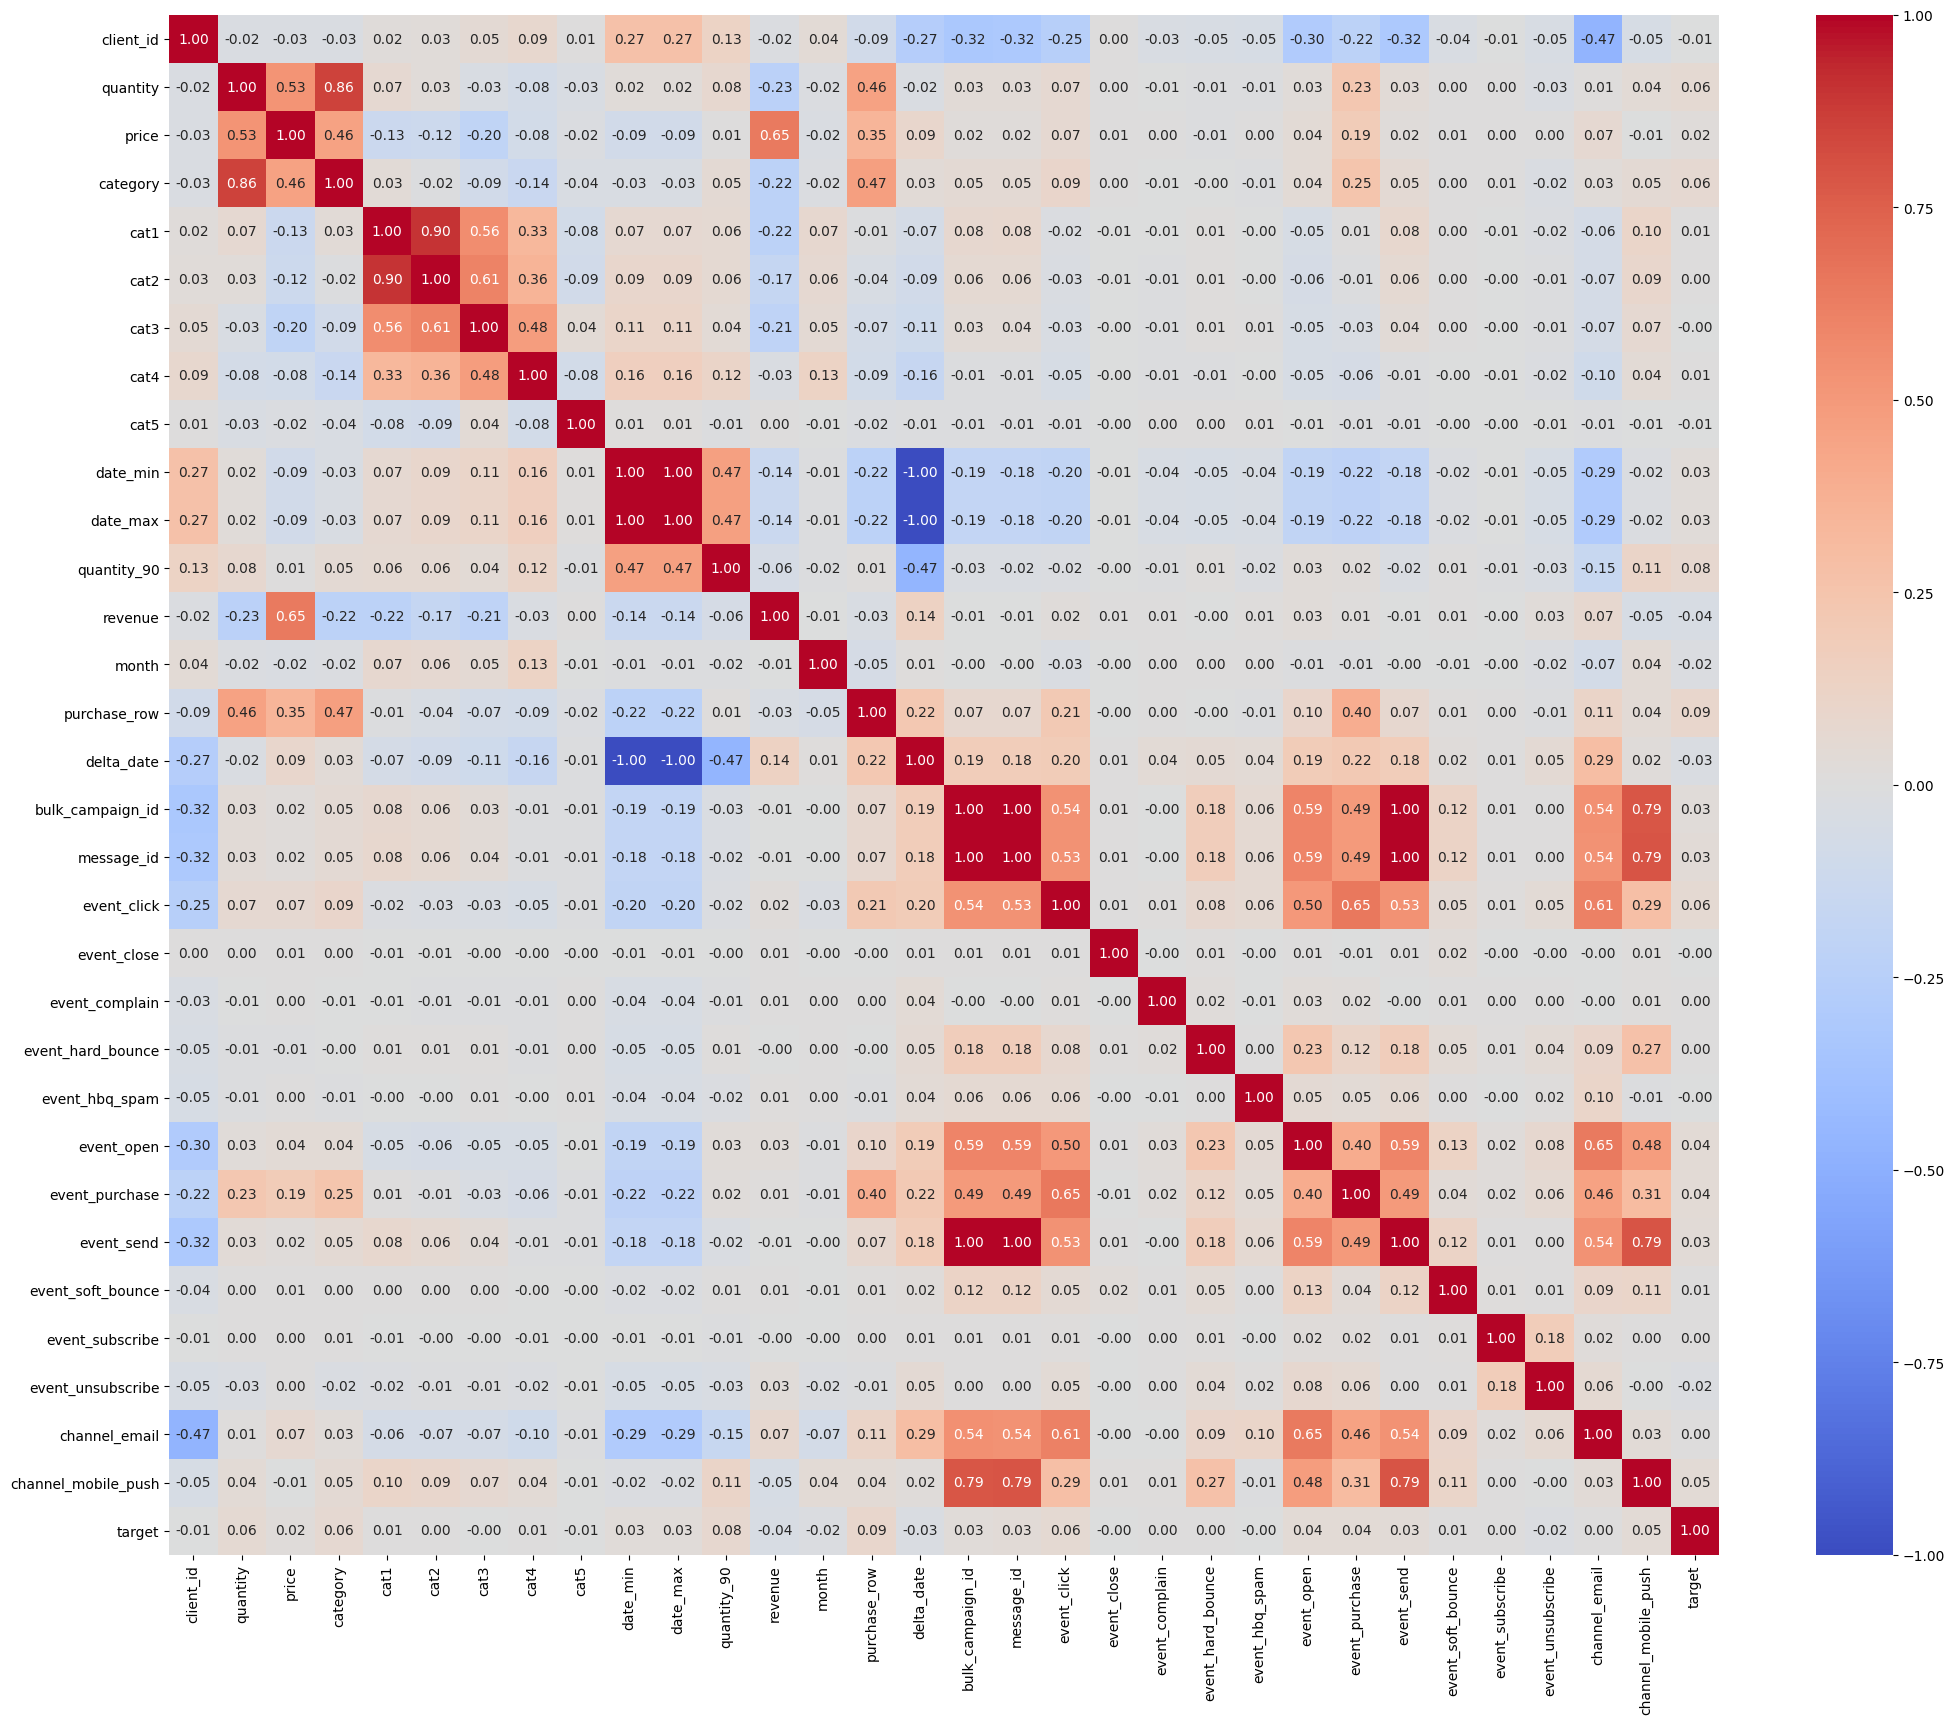

In [119]:
ax, fig = plt.subplots(figsize=(25,20))
sns.heatmap(corr_spearman, annot=corr_spearman, cmap='coolwarm', fmt='.2f',  annot_kws={"size":10});

In [120]:
df_group = df_group.drop([
   'date_min', 'bulk_campaign_id', 'channel_mobile_push',
   'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'event_close', 'event_subscribe'
],  axis=1)

In [121]:
corr_spearman = df_group.corr(method='spearman')

In [122]:
corr_spearman

,client_id,quantity,price,category,date_max,quantity_90,revenue,month,purchase_row,delta_date,...,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_unsubscribe,channel_email,target
client_id,1.000000,-0.024171,-0.030234,-0.027838,0.272124,0.128798,-0.015850,0.041095,-0.090313,-0.272124,...,-0.031269,-0.045648,-0.051628,-0.295571,-0.219638,-0.318965,-0.038943,-0.046756,-0.473496,-0.006466
quantity,-0.024171,1.000000,0.527323,0.856474,0.024523,0.075380,-0.229916,-0.020808,0.459184,-0.024523,...,-0.006587,-0.008528,-0.008968,0.029709,0.233978,0.033498,0.001315,-0.027178,0.009174,0.062288
price,-0.030234,0.527323,1.000000,0.456277,-0.093634,0.006888,0.646881,-0.023593,0.345369,0.093634,...,0.000371,-0.012200,0.004135,0.044300,0.189350,0.016891,0.007124,0.000214,0.065981,0.017075
category,-0.027838,0.856474,0.456277,1.000000,-0.032697,0.047754,-0.222123,-0.017576,0.473271,0.032697,...,-0.007274,-0.001687,-0.010555,0.044233,0.245457,0.049944,0.002200,-0.023572,0.027202,0.062637
date_max,0.272124,0.024523,-0.093634,-0.032697,1.000000,0.467444,-0.135897,-0.009876,-0.219210,-1.000000,...,-0.043916,-0.047720,-0.042813,-0.191898,-0.218085,-0.182087,-0.020174,-0.054032,-0.292105,0.029059
quantity_90,0.128798,0.075380,0.006888,0.047754,0.467444,1.000000,-0.056035,-0.015005,0.012297,-0.467444,...,-0.014209,0.010052,-0.017347,0.025245,0.018698,-0.024577,0.006681,-0.034976,-0.154965,0.076326
revenue,-0.015850,-0.229916,0.646881,-0.222123,-0.135897,-0.056035,1.000000,-0.005402,-0.032758,0.135897,...,0.006257,-0.004848,0.012578,0.030769,0.009643,-0.007472,0.005629,0.025878,0.072863,-0.042780
month,0.041095,-0.020808,-0.023593,-0.017576,-0.009876,-0.015005,-0.005402,1.000000,-0.054849,0.009876,...,0.000053,0.003518,0.003529,-0.012973,-0.008566,-0.003719,-0.005675,-0.017288,-0.074046,-0.021371
purchase_row,-0.090313,0.459184,0.345369,0.473271,-0.219210,0.012297,-0.032758,-0.054849,1.000000,0.219210,...,0.001843,-0.003079,-0.009384,0.100873,0.396310,0.072249,0.008548,-0.014551,0.111993,0.088912
delta_date,-0.272124,-0.024523,0.093634,0.032697,-1.000000,-0.467444,0.135897,0.009876,0.219210,1.000000,...,0.043916,0.047720,0.042813,0.191898,0.218085,0.182087,0.020174,0.054032,0.292105,-0.029059


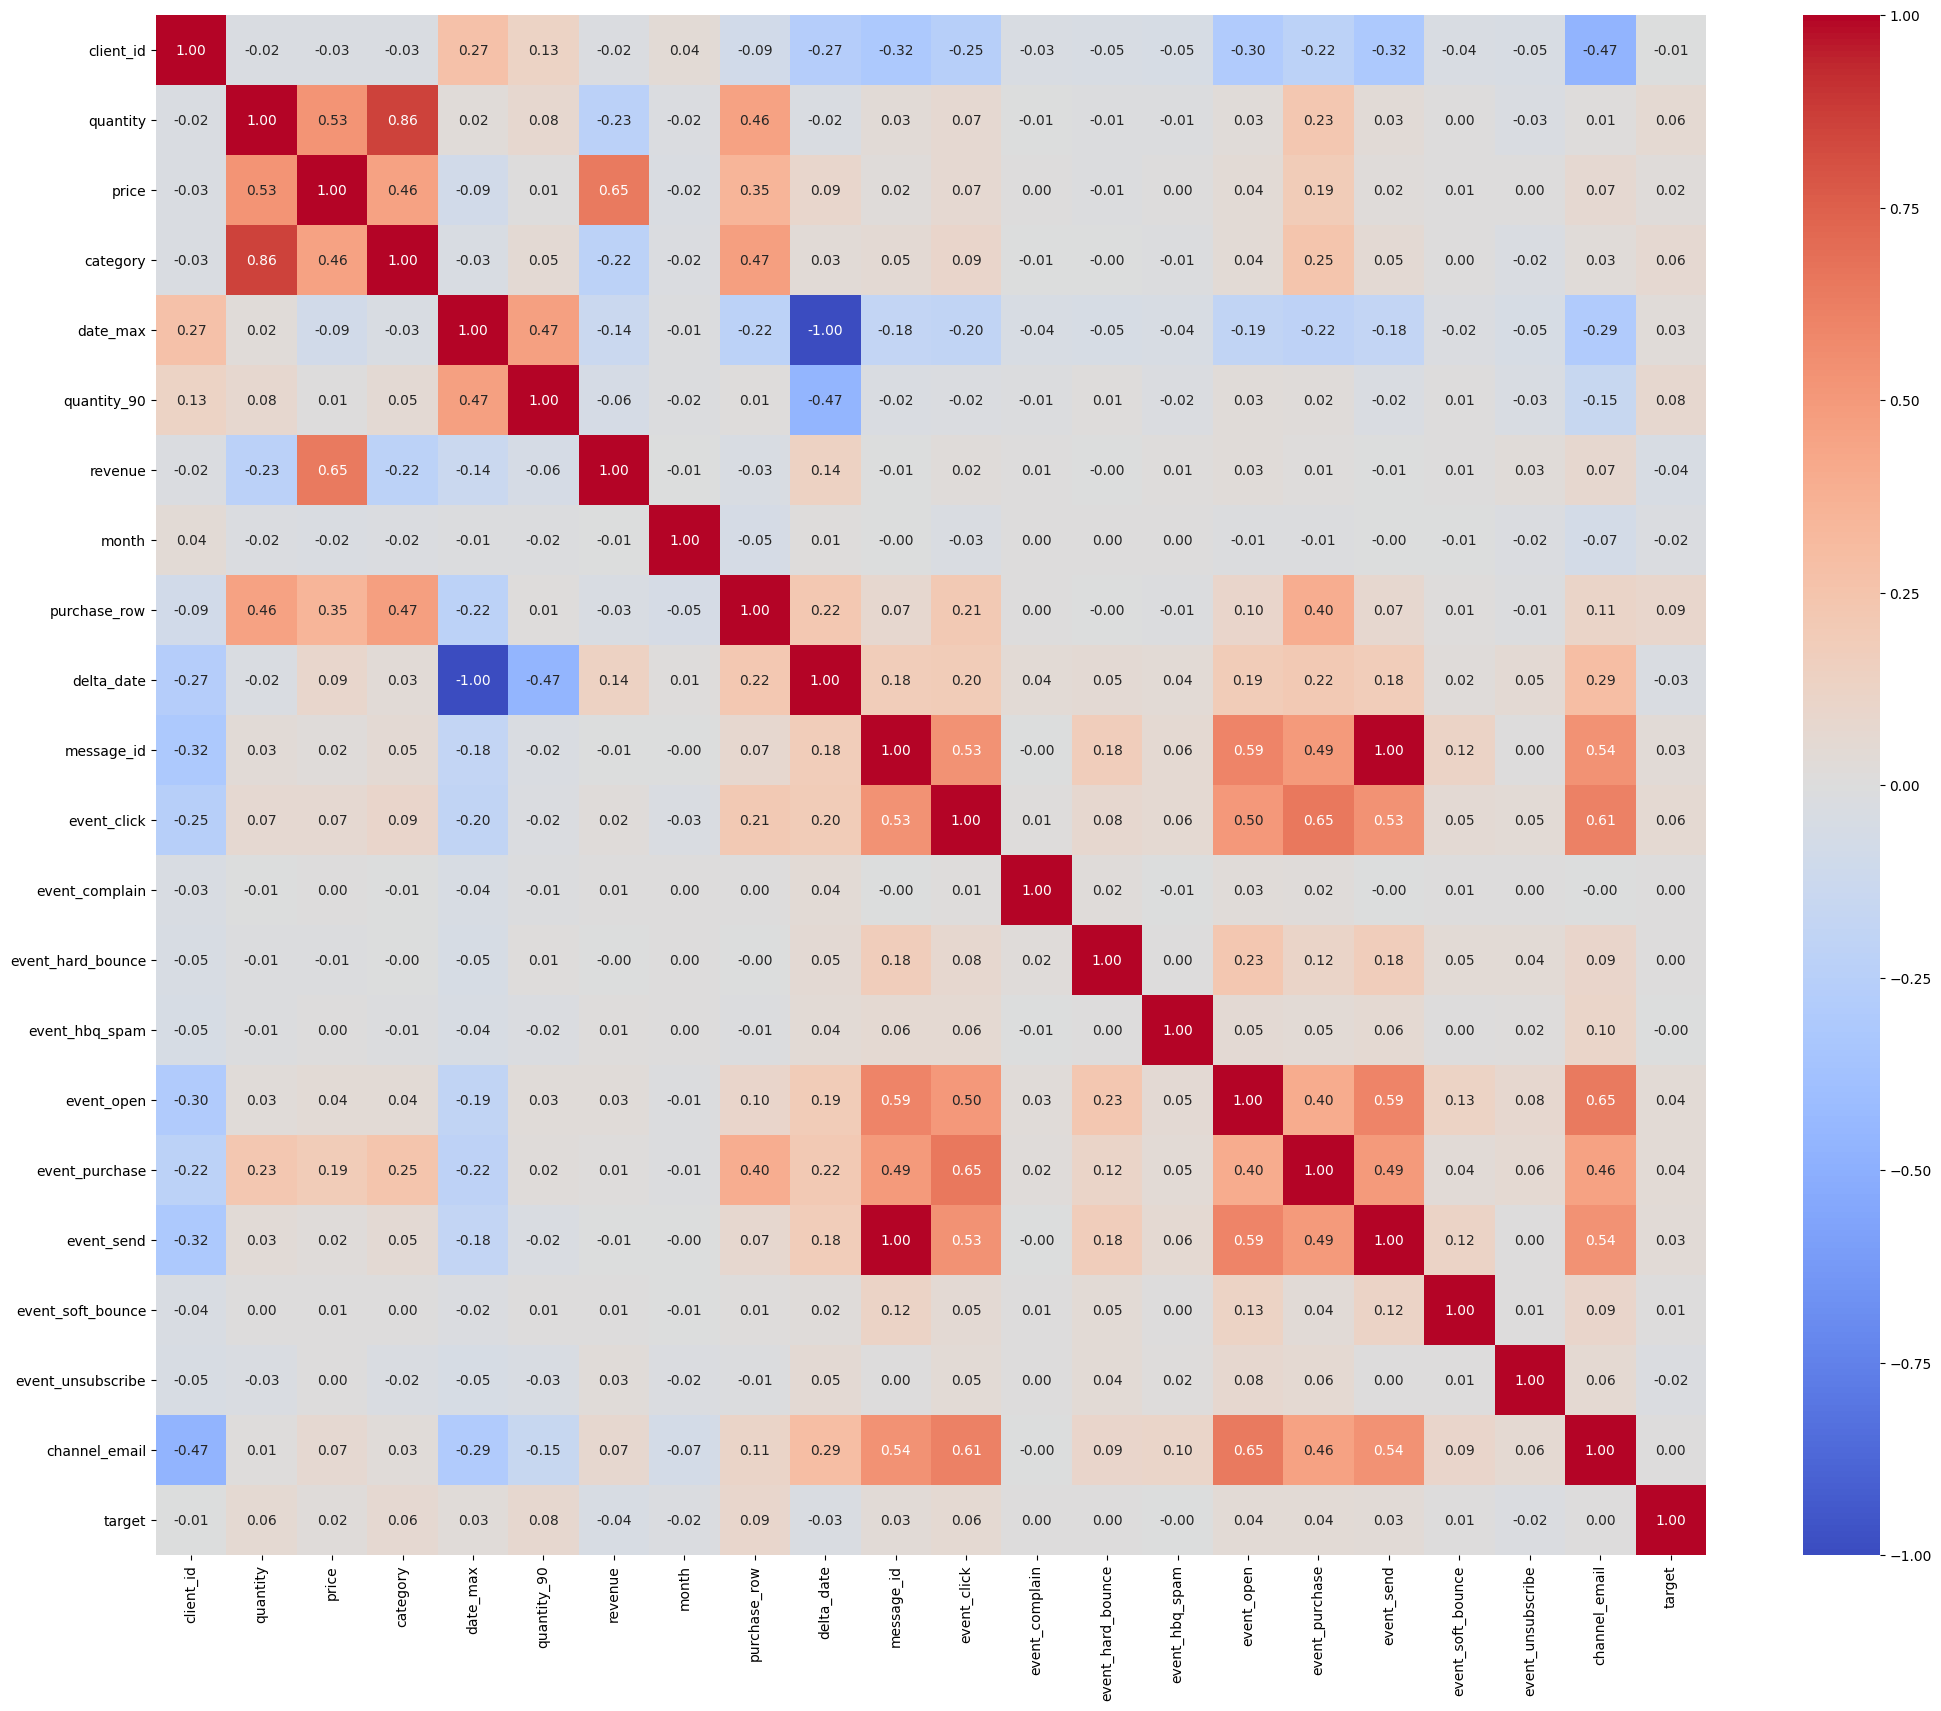

In [123]:
ax, fig = plt.subplots(figsize=(25,20))
sns.heatmap(corr_spearman, annot=corr_spearman, cmap='coolwarm', fmt='.2f',  annot_kws={"size":10});

**Вывод:** Выполнена проверка на мультиколлинеарность путем составления матрицы корреляции. Удалены сильно коррелирующие между собой входящие признаки. Также некоторые признаки удалены или оставлены в датасете постфактум, по результату экспериментов на моделях с разным набором признаков.

<a id='section_id6'></a>

## 5. Выбор и обучение модели

Для обучения и последующего прогнозирования целевого признака будем использовать пайплайн со следующими параметрами:
- масштабирование: StandardScaler(), MinMaxScaler(), RobustScaler()
- кодирование: не требуется, т.к. категориальные признаки отсутствуют
- обработка неизвестных значений:  SimpleImputer()
- модели:  LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), LGBMClassifier(), CatBoostClassifier()

Удалим из итогового датасета целевой признак и неинформативный идентификационный столбец 'client_id'

In [124]:
X = df_group.drop(['target', 'client_id'],  axis=1)
y = df_group['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=y
 )


num_columns = [
    'quantity', 'price', 'category', 'date_max',  'quantity_90', 'revenue', 'month', 'message_id',  'event_click',
    'event_complain', 'event_hard_bounce', 'event_hbq_spam', 'event_open', 'event_purchase', 'event_send',
    'event_soft_bounce', 'event_unsubscribe', 'channel_email', 'delta_date', 'purchase_row'   
]


             

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

Так как расчет пайплайна с большим количеством uиперпараметров методом GridSearchCV занимает значительное количество времени, а расчет с помощью RandomizedSearchCV дает нестабильный результат, разобьем расчет на 2 части:
- первый пайплайн выберет лучшую базовую модель из LogisticRegression, RandomForestClassifier, KNeighborsClassifier, LGBMClassifier и CatBoostClassifier
- на втором пайплайне добавим гиперпараметры для лучшей, по результатам раюоты первого пайплайна, модели

In [125]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    
     {
        'models': [RandomForestClassifier(
         random_state=RANDOM_STATE
        )],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    }, 
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    },    
    
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    }  
]


grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('Лучшая метрика на кросс-валидационной выборке:', grid_search.best_score_)

/home/pc-mint/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/pc-mint/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['quantity', 'price',
                                                   'category', 'date_max',
                                                   'quantity_90', 'revenue',
                                                   'month', 'message_id',
                                                   'event_click',
                                                   'event_complain',
                                                   'event_hard_bounce',
                                                   'event_hbq_spam',
                                                   'event_open',
                                                   'event_purchase',
                                                   'event_send',
                             

In [126]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__class_weight,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.203483,0.021152,0.030768,0.001159,LogisticRegression(random_state=42),balanced,StandardScaler(),{'models': LogisticRegression(random_state=42)...,0.697581,0.729365,0.760986,0.730371,0.745206,0.732702,0.021007,2
1,0.389843,0.059844,0.037240,0.008164,LogisticRegression(random_state=42),balanced,MinMaxScaler(),{'models': LogisticRegression(random_state=42)...,0.698453,0.725088,0.754199,0.730362,0.747623,0.731145,0.019540,3
2,0.360473,0.079776,0.033457,0.007779,LogisticRegression(random_state=42),balanced,RobustScaler(),{'models': LogisticRegression(random_state=42)...,0.697636,0.729350,0.760945,0.730367,0.745298,0.732719,0.020989,1
3,0.759132,0.094198,0.023456,0.002345,LogisticRegression(random_state=42),balanced,passthrough,{'models': LogisticRegression(random_state=42)...,0.655337,0.658977,0.675404,0.654647,0.694300,0.667733,0.015272,27
4,0.158154,0.018002,0.026240,0.002173,LogisticRegression(random_state=42),None,StandardScaler(),{'models': LogisticRegression(random_state=42)...,0.686976,0.726201,0.754767,0.729804,0.745954,0.728740,0.023348,4
5,0.155525,0.021762,0.027318,0.007238,LogisticRegression(random_state=42),None,MinMaxScaler(),{'models': LogisticRegression(random_state=42)...,0.694599,0.711223,0.732923,0.716500,0.736847,0.718419,0.015315,9
6,0.268076,0.050422,0.031752,0.004732,LogisticRegression(random_state=42),None,RobustScaler(),{'models': LogisticRegression(random_state=42)...,0.687226,0.724688,0.754196,0.728726,0.746917,0.728351,0.023313,5
7,0.571306,0.033319,0.017747,0.005032,LogisticRegression(random_state=42),None,passthrough,{'models': LogisticRegression(random_state=42)...,0.624915,0.656403,0.669520,0.629801,0.687357,0.653599,0.023622,28
8,6.306482,0.502736,0.159332,0.017496,RandomForestClassifier(random_state=42),balanced,StandardScaler(),{'models': RandomForestClassifier(random_state...,0.676222,0.641634,0.669518,0.672989,0.687116,0.669496,0.015128,26
9,6.514889,0.519617,0.152491,0.019186,RandomForestClassifier(random_state=42),balanced,MinMaxScaler(),{'models': RandomForestClassifier(random_state...,0.681111,0.645454,0.670734,0.671963,0.688043,0.671461,0.014459,24


По результатам работы пайплайна выше, определена лучшая модель - LogisticRegression. Уточним гиперпараметры этой модели для улучшения метрики на кросс-валидации

In [127]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__C': [.1, 1, 2, 3, 5, 10, 12],
        'models__penalty': ['l1', 'l2', 'elasticnet'],
        'models__class_weight': ['balanced', None],
        'models__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }

]


grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('Лучшая метрика на кросс-валидационной выборке:', grid_search.best_score_)

/home/pc-mint/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pc-mint/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pc-mint/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pc-mint/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pc-mint/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['quantity', 'price',
                                                   'category', 'date_max',
                                                   'quantity_90', 'revenue',
                                                   'month', 'message_id',
                                                   'event_click',
                                                   'event_complain',
                                                   'event_hard_bounce',
                                                   'event_hbq_spam',
                                                   'event_open',
                                                   'event_purchase',
                                                   'event_send',
                             

Определим прогнозные значения и вероятности на тестовой выборке

In [128]:
predict =  grid_search.best_estimator_.predict(X_test)
probas = grid_search.best_estimator_.predict_proba(X_test)

Посчитаем метрики (accuracy, ROC-AUC, F1, recall, precision) и выведем матрицу ошибок.

Accuracy = 0.74
ROC-AUC = 0.745
F1-score = 0.086
recall = 0.637
precision = 0.046


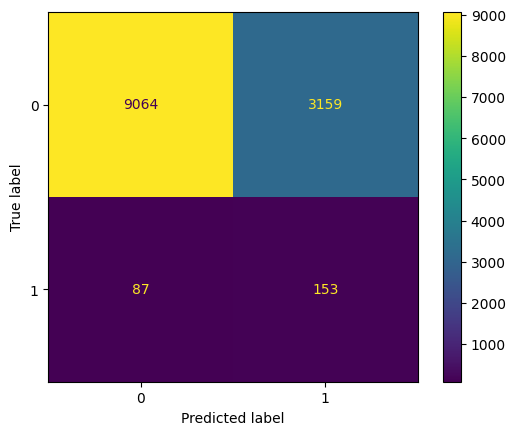

In [129]:
# считаем и выводим accuracy
acc = accuracy_score(y_test, predict)
print('Accuracy =', round(acc,3))

# считаем и выводим ROC-AUC
roc = roc_auc_score(y_test, probas[:,1])
print('ROC-AUC =', round(roc,3))

# считаем и выводим F1-меру
f1 = f1_score(y_test, predict, pos_label=1)
print('F1-score =', round(f1,3)) 

# считаем и выводим recall
recall = recall_score(y_test, predict, pos_label=1)
print('recall =', round(recall,3)) 

# считаем и выводим precision
precision = precision_score(y_test, predict, pos_label=1)
print('precision =', round(precision,3)) 


# построим матрицу ошибок 
cm = confusion_matrix(y_test, predict)
cmp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
cmp.plot();

**Вывод:** По результату обучения на тренировочной выборке, определены следующие парааметры модели/пайплайна, формирующие наилучшие результаты на кросс-валидационной выборке:

- масштабирование: RobustScaler()
- кодирование:  не требуется
- модель:   LogisticRegression(C=2, class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])
- метрика ROC- AUC на кросс-валидационной выборке: 0.733
- метрики на тестовой выборке:

  Accuracy = 0.74  
  ROC-AUC = 0.745  
  F1-score = 0.086  
  recall = 0.638  
  precision = 0.046

Также по матрице ошибок можно заметить, что среди 240 потенциальных покупателей, модель верно определила 153 клиента, что составило 64%, однако также модель ошибочно определила 3159 клиентов, которые не будут делать покупки, как потенциальных покупателей. Отделу маркетинга стоит учесть данный факт при формировании рекламных рассылок клиентам.

    
<a id='section_id7'></a>

## 6. Анализ важности признаков лучшей модели

Оценим важность признаков, для модели с наилучшими значениями метрик, полученной в разделе выше и построим график важности с помощью метода SHAP:

Применим лучшую модель, полученную по итогам работы пайплайна:

In [130]:
model = grid_search.best_estimator_

In [131]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['quantity', 'price',
                                                   'category', 'date_max',
                                                   'quantity_90', 'revenue',
                                                   'month', 'message_id',
                                                   'event_click',
                                                   'event_complain',
                                                   'event_hard_bounce',
                                                   'event_hbq_spam',
                                                   'event_open',
                                                   'event_purchase',
                                                   'event_send',
                                                   'event_soft_bounce',
                                                   'event_unsubscribe',
                                                   'channel_email',
                                                   'delta_date',
                                                   'purchase_row'])])),
                ('models',
                 LogisticRegression(C=2, class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])

Обучим и преобразуем массив X_train:

In [132]:
model['preprocessor'].fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 ['quantity', 'price', 'category', 'date_max',
                                  'quantity_90', 'revenue', 'month',
                                  'message_id', 'event_click', 'event_complain',
                                  'event_hard_bounce', 'event_hbq_spam',
                                  'event_open', 'event_purchase', 'event_send',
                                  'event_soft_bounce', 'event_unsubscribe',
                                  'channel_email', 'delta_date',
                                  'purchase_row'])])

In [133]:
X_train_preprocessed = model['preprocessor'].transform(X_train)

Выделим имена столбцов массива X_train, полученные после преобразования кодировщиком и скейлером:

In [134]:
column_names = model['preprocessor'].get_feature_names_out()

In [135]:
data = pd.DataFrame(X_train_preprocessed, columns=column_names)

In [136]:
data.head()

,num__quantity,num__price,num__category,num__date_max,num__quantity_90,num__revenue,num__month,num__message_id,num__event_click,num__event_complain,num__event_hard_bounce,num__event_hbq_spam,num__event_open,num__event_purchase,num__event_send,num__event_soft_bounce,num__event_unsubscribe,num__channel_email,num__delta_date,num__purchase_row
0,0.00000,0.011565,0.000000,0.030203,0.000000,0.041198,0.909091,0.041245,0.021053,0.0,0.0,0.0,0.022082,0.012346,0.041245,0.0,0.000,0.159770,0.969797,0.00000
1,0.00625,0.031818,0.000000,0.009797,0.000000,0.056662,0.545455,0.052568,0.000000,0.0,0.0,0.0,0.000789,0.000000,0.052972,0.0,0.000,0.151724,0.990203,0.04878
2,0.00625,0.021978,0.000000,0.000203,0.000000,0.039136,0.363636,0.010918,0.007895,0.0,0.0,0.0,0.011830,0.012346,0.010918,0.0,0.375,0.056322,0.999797,0.00000
3,0.03125,0.041641,0.078947,0.528528,0.083333,0.024705,0.727273,0.051759,0.013158,0.0,0.0,0.0,0.007886,0.024691,0.051759,0.0,0.000,0.166667,0.471472,0.04878
4,0.06250,0.026493,0.131579,0.543858,0.305556,0.008561,1.000000,0.069147,0.015789,0.0,0.0,0.0,0.000000,0.012346,0.069147,0.0,0.000,0.000000,0.456142,0.00000


In [137]:
masker = shap.maskers.Independent(data = data)

In [138]:
explainer = shap.LinearExplainer(model['models'], masker=masker)
shap_values = explainer(data)

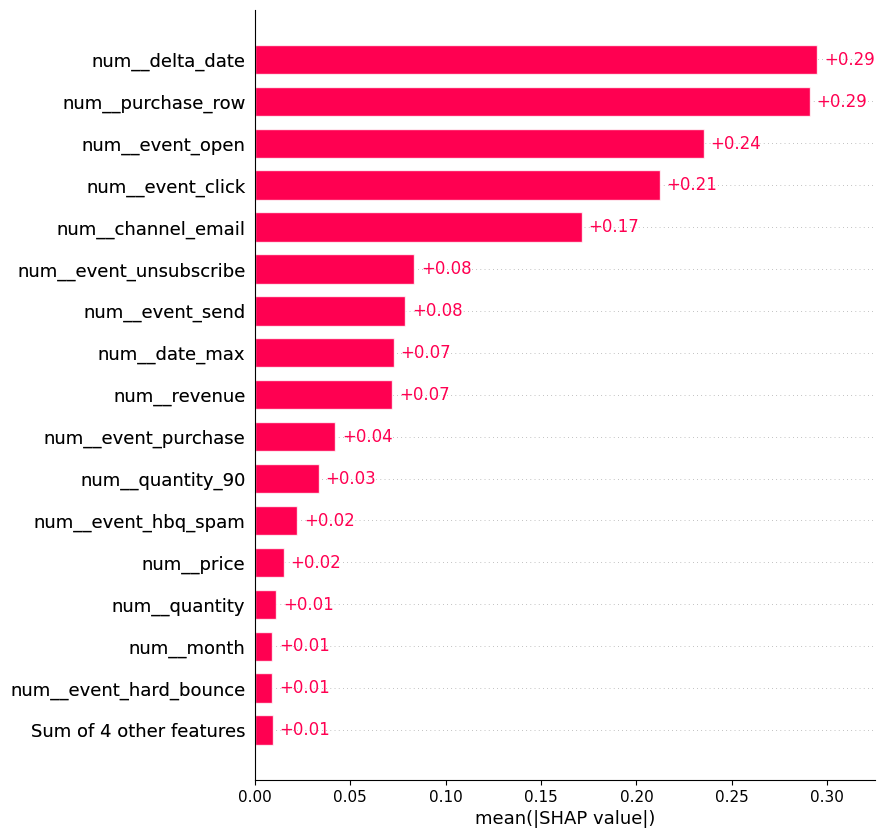

In [139]:
shap.plots.bar(shap_values, max_display=17) 

**Вывод:** По результатам анализа полученных графиков, можно прийти к следующим выводам:
Возьмем за границу, разделяющую важные признаки от неважных - среднее значение Шепли, равные 0.05.
Тогда получим, что:
- менее на прогноз целевого признака влияют следующие входные параметры: 'revenue', 'date_max', 'event_send', 'event_unsubscribe';
- более всего на прогноз целевого признака влияют следующие входные параметры: 'channel_email', 'event_click', 'event_open',  'purchase_row', 'delta_date'.

На основании описанного выше, для повышения вероятности совершения покупки клиентом, стоит направлять рекламные рассылки людям, которые в совершали покупку в один из ближайших дней и при этом также они совершали одну и более покупок в другие дни до этого.
<a id='section_id8'></a>

## 7. Общий вывод

Целью настоящего исследования является разработка модели, определяющей пользователей, которые готовы совершить покупку в ближайшее время

Необходимые для исследования данные загружены, проверены на корректность отображения, также выведены основные статистические параметры датасетов.

В рамках предварительной обработки:

- загружены необходимые для исследования датасеты;
- датасеты проверены на корректность вывода;
- датасет проверен на наличие пропусков в данных (пропуски не выявлены);
- данные проверены на наличие явных дубликатов, выяыленные дубликаты удалены из датасета;
- значения, отображающие даты событий, переведены из строкового формата в формат datetime.

В рамках исследовательского анализа:

-  выявлено сильное преобладание значения 1 в столбце 'quantity' датасета df_purchases;
-  выявлено различие между минимальной и максимальной датой датасетов df_purchases и df_messages, также выявлено что топ-20 самых распространенных значений дат датасета df_purchases представлены годами 2022 и 2023, в то время когда топ-20 датасета df_messages представлены годами 2023 и 2024;
-  выявлен дисбаланс в значениях целевого признака: количество клиентов имеющих метку 0 (клиент не сделает покупку) сильно превалирует над количеством клиентов с меткой 1 (клиент сделает покупку).


Разработан следующие синтетические признаки: 

- 'quantity_90' - количество товаров, приобретенных в последние 90 дней;
- 'month' - номер месяца покупки;
- 'revenue' - выручка полусченная от клиента;
- 'cat1', 'cat2', 'cat3', 'cat4', 'cat5' - уровни категорий по стоkбцу 'category_ids';
- 'purchase_row' - количество дней,  в которые были совершены покупки (если таких дней было более 1)
- 'date_min' - минимальная дата покупки;
- 'date_max' - максимальная дата покупки;
- 'delta_date' - разница между самой поздней покупкой в датасете и самой поздней покупкой у конкретного клиента;
- 'event_X' - где X это все уникальные значения столбца event;
- 'channel_X' - где X это все уникальные значения столбца channel.
 
Выполнена проверка на мультиколлинеарность путем составления матрицы корреляции. Удалены сильно коррелирующие между собой входящие признаки. Также некоторые признаки удалены или оставлены в датасете постфактум, по результату экспериментов на моделях с разным набором признаков.

По результату обучения на тренировочной выборке, определены следующие парааметры модели/пайплайна, формирующие наилучшие результаты на кросс-валидационной выборке:

- масштабирование: RobustScaler()
- кодирование:  не требуется
- модель:   LogisticRegression(C=2, class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])
- метрика ROC- AUC на кросс-валидационной выборке: 0.733
- метрики на тестовой выборке:

  Accuracy = 0.74  
  ROC-AUC = 0.745  
  F1-score = 0.086  
  recall = 0.638  
  precision = 0.046

Также матрица ошибок показала, что среди 240 потенциальных покупателей, модель верно определила 153 клиента, что составило 64%, однако также модель ошибочно определила 3159 клиентов, которые не будут делать покупки, как потенциальных покупателей. Отделу маркетинга стоит учесть данный факт при формировании рекламных рассылок клиентам.


По результатам анализа SHAP графиков, можно прийти к следующим выводам:
Возьмем за границу, разделяющую важные признаки от неважных - среднее значение Шепли, равные 0.05.
Тогда получим, что:
- менее на прогноз целевого признака влияют следующие входные параметры: 'revenue', 'date_max', 'event_send', 'event_unsubscribe';
- более всего на прогноз целевого признака влияют следующие входные параметры: 'channel_email', 'event_click', 'event_open',  'purchase_row', 'delta_date'.

На основании описанного выше, для повышения вероятности совершения покупки клиентом, стоит направлять рекламные рассылки людям, которые в совершали покупку в один из ближайших дней и при этом также они совершали одну и более покупок в другие дни до этого.